In [64]:
!pip install langgraph langsmith langchain langchain_groq langchain_community

In [65]:
from typing import Annotated
from typing_extensions import TypedDict

In [66]:
!pip install wikipedia arxiv

In [67]:
# Working with External tools

from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

# Arxive and Wikipedia tools

arxive_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=300)
arxiv_tool = ArxivQueryRun(api_wrapper=arxive_wrapper)

wiki_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)
wiki_tool = WikipediaQueryRun(api_wrapper=wiki_wrapper)

In [68]:
wiki_tool.invoke("Who is Sharukh Khan?")

'Page: Shah Rukh Khan\nSummary: Shah Rukh Khan (pronounced [ˈʃɑːɦɾʊx xɑːn] ; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi cinema. Referred to in the media as the "Baadshah of Bollywood" and "King Khan", he has appeared in more than 10'

In [69]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [70]:
tools = [wiki_tool]

In [71]:
# Langgraph Application
from langgraph.graph.message import add_messages

class State(TypedDict):
  messages: Annotated[list, add_messages]



In [72]:
from langgraph.graph import StateGraph, START, END

In [73]:
graph_builder = StateGraph(State)

In [74]:
from langchain_groq import ChatGroq

In [75]:
from google.colab import userdata
groq_api_key = userdata.get('GROQ_API_KEY')


In [76]:
llm = ChatGroq(groq_api_key=groq_api_key, model_name = 'Gemma2-9b-IT')

In [77]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7e39552b0e20>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7e3955333220>, model_name='Gemma2-9b-IT', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [78]:
llm_with_tools = llm.bind_tools(tools=tools)

In [79]:
def chatbot(state:State):
  return {"messages": [llm_with_tools.invoke(state['messages'])]}

In [80]:
from langgraph.prebuilt import ToolNode, tools_condition

In [81]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

In [82]:
graph = graph_builder.compile()

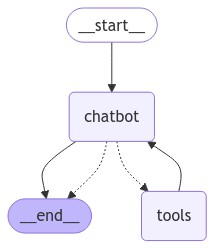

In [83]:
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  # This requires some extra dependencies and is optional
  pass

In [88]:
user_input = "Hi There! My name is Shamshad"
events = graph.stream(
    {"messages": [("user", user_input)]}, stream_mode='values'
)



In [89]:
for event in events:
  event['messages'][-1].pretty_print()

================================ Human Message =================================

Hi There! My name is Shamshad
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_s00c)
 Call ID: call_s00c
  Args:
    query: Shamshad


/usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


================================= Tool Message =================================
Name: wikipedia

No good Wikipedia Search Result was found
================================== Ai Message ==================================

Hi Shamshad!  It seems like I don't have much information about you from Wikipedia.  Would you like to tell me more about yourself?
